In [ ]:
# Ameya Baxi (some collaboration with lab team members)
# COMP SCI 320: Data Science Programming II, Fall 2022
# Project 6: Regression Models

# using regression models to make predictions about Wisconsin census data 
# project instructions: https://github.com/cs320-wisc/f22/tree/main/p6

In [1]:
# project: p6
# submitter: abaxi
# partner: none
# hours: 5

In [2]:
import geopandas as gpd
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import rasterio
from rasterio.mask import mask
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
#Q1
#How many counties are in Wisconsin?

# create a GeoDataFrame from counties.geojson
gdf = gpd.read_file("counties.geojson")

# number of counties in Wisconsin
num_counties = len(gdf)

# answer
num_counties

72

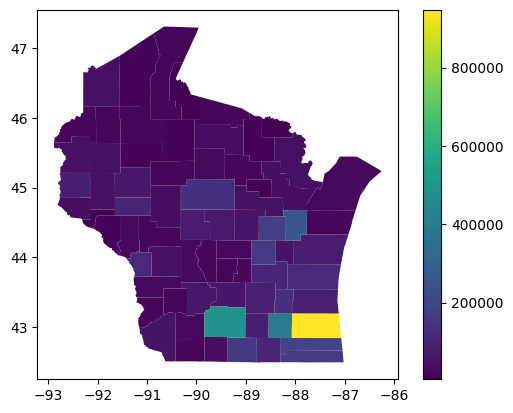

In [4]:
#Q2
#What is the population of each county in WI?

gdf.plot(column = "POP100", legend = True)
None

In [5]:
#FEATURE1: AREALAND
#Add AREALAND column to gdf to predict population based on area

# connect to counties_tracts database
conn = sqlite3.connect("counties_tracts.db")

# add AREALAND column to gdf
gdf["AREALAND"] = pd.read_sql("""SELECT AREALAND FROM counties""", conn)

# split gdf rows into train and test datasets
train, test = train_test_split(gdf, random_state = 250, test_size = 0.25)

In [6]:
#Q3
#What are the counties in the test dataset?

# list of counties in test dataset
test_counties = test["NAME"].to_list()

# answer
test_counties

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4
#How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?

x = ["AREALAND"]
y = "POP100"

lin_reg = LinearRegression()
lin_reg.fit(train[x], train[y])
lin_reg.score(test[x], test[y])

0.016720430179409274

In [8]:
#Q5
#What is the predicted population of a county with 400 square miles of area, according to the model?

# 1 sq mi = 2.59 sq km
# 1 sq km = 1000000 m
# AREALAND is measured in sq m
# need to convert 400 sq mi to sq m

sq_m = 400 * 2.59 * 1000000

predict_df = pd.DataFrame({"AREALAND": [sq_m]})
predict_df["predicted population"] = lin_reg.predict(predict_df)

# answer
float(predict_df["predicted population"])

90000.07422783462

In [9]:
#FEATURE2: HU100 (housing units)

sql = pd.read_sql("""SELECT tracts.county, counties.name, SUM(HU100) AS HU100 FROM tracts INNER JOIN counties ON tracts.county = counties.county GROUP BY tracts.county""", conn)

hu100_list = []
for n in gdf["NAME"]:
    idx = 0
    for s in sql["NAME"]:
        if n == s:
            hu100_list.append(sql.loc[idx]["HU100"])
        else:
            idx += 1
    
gdf["HU100"] = pd.Series(hu100_list)

train, test = train_test_split(gdf, random_state = 250, test_size = 0.25)

In [10]:
#Q6
#What are the counties in the test dataset?

# copied from https://cmdlinetips.com/2021/04/convert-two-column-values-from-pandas-dataframe-to-a-dictionary/#:~:text=Another%20approach%20to%20convert%20two,all%20columns%20in%20the%20dataframe.
# list of counties in test dataset
test_counties = test["NAME"].to_list()

# answer
test_counties

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7
#What are the HU100 values for the counties in the test dataset?

hu100_dict = test.set_index("NAME").to_dict()["HU100"]

# answer
hu100_dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8
#How much variance in the POP100 can a LinearRegression model explain based only on HU100?

# use average of 5 scores produced by cross_val_score on training data

x = ["HU100"]
y = "POP100"
lin_reg.fit(train[x], train[y])
scores = cross_val_score(lin_reg, train[x], train[y])
mean = scores.mean()

# answer
mean

0.9739348181232653

In [13]:
#Q9
#What is the standard deviation of the cross validation scores from Q8?

scores.std()

0.01693954236334351

In [14]:
#Q10
#What is the formula relating POP100 and HU100?

f"POP100 = {round(lin_reg.coef_[0], 2)}*HU100 + {round(lin_reg.intercept_, 2)}"

'POP100 = 2.47*HU100 + -9276.89'

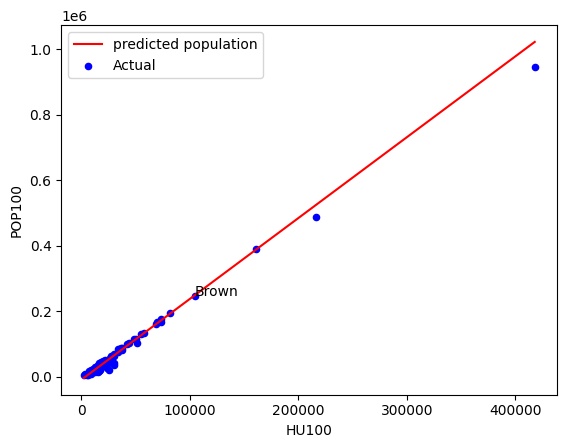

In [15]:
#Q11
#What is the relationship between HU100 and POP100, visually?

lin_reg.fit(train[x], train[y])
lin_reg.score(test[x], test[y])

predict_df = pd.DataFrame({"HU100": range(gdf["HU100"].min(), gdf["HU100"].max())})
predict_df["predicted population"] = lin_reg.predict(predict_df)

ax = predict_df.plot.line(x = "HU100", y = "predicted population", color = "red")
ax.text(gdf[gdf["NAME"] == "Brown County"]["HU100"], gdf[gdf["NAME"] == "Brown County"]["POP100"], "Brown")
gdf.plot.scatter(x = "HU100", y = "POP100", ax = ax, color = "blue", legend = True, label = "Actual")
None

In [16]:
#Q12
#How many numbers in matrix A are between 3 and 6 (inclusive)?

c = 0

# matrix A
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

# from NumPy documentation
for n in np.nditer(A):
    if 3 <= n <= 6:
        c += 1

# answer
c

8

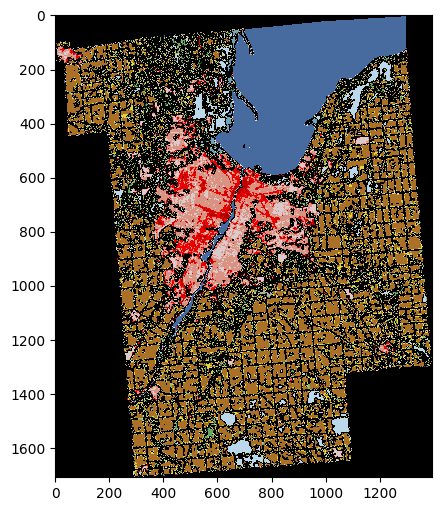

In [17]:
#Q13
#How does Brown County look?

land = rasterio.open("zip://../p6/land.zip!wi.tif")

matrix, _ = mask(land, gdf[gdf["NAME"] == "Brown County"].to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)
    
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)
None

In [18]:
#Q14
#What portion of Brown County is "Open Water"?

land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

(matrix == land_use["open_water"]).astype(int).sum() / (matrix != 0).astype(int).sum()

0.13797526789725206

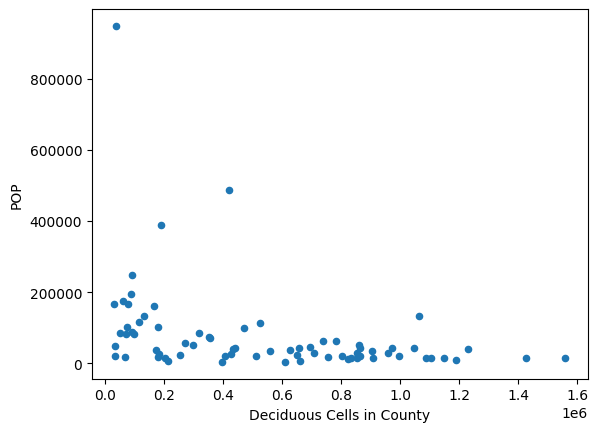

In [19]:
#Q15
#What is the Relationship Between POP100 and ________________?

idx = 0



for county in gdf["NAME"]: 
    cmatrix, _ = mask(land, gdf[gdf["NAME"] == county].to_crs(land.crs)["geometry"], crop=True)
    cmatrix = cmatrix[0]
    cellcount = (cmatrix == land_use["deciduous"]).astype(int).sum()
    gdf.at[idx, "DECIDUOUS"] = cellcount
    idx += 1
    
gdf.plot.scatter(x = "DECIDUOUS", y = "POP100", xlabel = "Deciduous Cells in County", ylabel = "POP")
None